In [1]:
%pip install pyarrow==12.0.1 --index-url https://pypi.org/simple > /dev/null 2>&1
%conda install -c conda-forge cmake > /dev/null 2>&1


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install -r requirements.txt --index-url https://pypi.org/simple > /dev/null 2>&1

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import ast
import json
import random
import pandas as pd
import pandas as pd
from backend.scripts.utils import query_gai_via_gateway
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import datetime
from nltk.tokenize import sent_tokenize
from backend.scripts.utils import gai
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()


os.environ["DB_HOST"] = "localhost"
os.environ["POSTGRES_USER"] = "matthew50"
os.environ["POSTGRES_PASSWORD"] = "softpower"
os.environ["POSTGRES_DB"] = "softpower-db"
from backend.scripts.utils import Config
from backend.app import app
from backend.extensions import db
from backend.scripts.models import(SoftPowerActivity, 
                                   Document, 
                                   Category, 
                                   InitiatingCountry, 
                                   RecipientCountry, 
                                   DailySummary,
                                   DailyCategory,
                                   DailyRecipient,
                                   CountrySummary,
                                   Subcategory,
                                   Event,
                                   EventSources,
                                   EventSummary,
                                   TokenizedDocuments,
                                   SummarySources)
from dotenv import load_dotenv
from sqlalchemy.dialects.postgresql import insert
from sqlalchemy import func
load_dotenv()
cfg = Config.from_yaml()
app.app_context().push()
db.session.remove()
db.engine.dispose()
# reporting = (db.session.query(Document.doc_id,
#                             Document.date,
#                             Document.title,
#                             Document.distilled_text,
#                             Document.salience_justification,
#                             Category.category)
#                             .join(Category,Document.doc_id==Category.doc_id)
#                             .join(InitiatingCountry,Document.doc_id==InitiatingCountry.doc_id)
#                             .join(RecipientCountry,Document.doc_id==RecipientCountry.doc_id)
#                             .filter(Document.date.between(start,end),
#                             InitiatingCountry.initiating_country==country,
#                             RecipientCountry.recipient_country.in_(cfg.recipients),
#                             Category.category==category).all()
# )

def file_name(country,start_date,end_date,category,recipient):
    filename = ''
    if country:
        filename += f'{country}'
    if recipient:
        filename += f'_{recipient}'
    filename += f'_{start_date}_{end_date}'
    if category:
        filename += f'_{category}'
    return filename

# Preprocessing
def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in STOPWORDS]
    stemmed_tokens = [STEMMER.stem(word) for word in filtered_tokens]
    # Open a session within the thread context
    return ' '.join(stemmed_tokens)

def find_related_articles(event_description, article_vectors, vectorizer, articles):
    # Vectorize the event description
    event_vector = vectorizer.transform([event_description])
    # Compute similarity
    similarities = cosine_similarity(event_vector, article_vectors)
    return similarities.flatten()

def source_summary(records,summary,summ_type):
    if summ_type=='overview':
        summ = summary['overview']
    else:
        summ = summary['outcome']
    sys_prompt = source_sys_prompt
    user_prompt = source_user_prompt.format(title=summary['key_event'], summary=summ, reports=records)
    source_response = gai(sys_prompt=sys_prompt, user_prompt=user_prompt,model="gpt-41")
    # source_output = fetch_gai_content(source_response)
    return source_response

def source_summaries(summaries, records):
    source_outputs = []
    if len(records) > 200:
        print('sampling records...')
        records = records.nlargest(200, 'similarity_score')
    # Source sentences for each summary
    for summary in summaries:
        print(f'processing {summary["id"]}')
        overview_output = source_summary(records,summary,summ_type='overview')
        outcome_output = source_summary(records,summary,summ_type='outcome')
        # insert_sentence_sourcing(gai_output=source_output,sentence=sentence,summary=summary)
    return overview_output,outcome_output

def fetch_gai_sources(output):
    sources = output['choices'][0]['message']['content'].replace('[','').replace(']','').replace("\n",'').replace("{","").replace("}","").replace("doc_id","").replace(":","").replace(' ','').strip().split(',')
    if sources:
        return sources 
    else:
        print(f"error: {sources}")
        return []
def clean_string(x):
    # Remove brackets, braces, parentheses, quotes, the word doc_id, colons, spaces, and newlines
    return re.sub(r"[\[\]\{\}\(\)'\:\s\n]|doc_id", "", x)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/ec2-user/SageMaker/.cs/conda/envs/codeserver_py39/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ec2-user/SageMaker/.cs/conda/envs/codeserver_py39/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/SageMaker/.cs/conda/envs/codeserver_py39/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/SageMaker/.cs/conda/envs/codes

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/ec2-user/SageMaker/.cs/conda/envs/codeserver_py39/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ec2-user/SageMaker/.cs/conda/envs/codeserver_py39/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/SageMaker/.cs/conda/envs/codeserver_py39/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/SageMaker/.cs/conda/envs/codes

AttributeError: _ARRAY_API not found

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/ec2-user/SageMaker/.cs/conda/envs/codeserver_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sagemaker-user/SoftPowerCLI/backend/scripts/embedding_vectorstore.py:20: LangChainPendingDeprecationWarning: This class is pending deprecation and may be removed in a future version. You can swap to using the `PGVector` implementation in `langchain_postgres`. Please read the guidelines in the doc-string of this class to follow prior to migrating as there are some differences between the implementations. See 

ImportError: cannot import name 'DailyCategory' from 'backend.scripts.models' (/home/sagemaker-user/SoftPowerCLI/backend/scripts/models.py)

In [3]:
app.app_context().push()
db.session.remove()
db.engine.dispose()
sources = db.session.query(Document.doc_id,Document.source_name).limit(100).all()

In [6]:
df_sources = pd.DataFrame([x for x in sources])
sources = list(set([x for x in df_sources['source_name']]))

In [7]:
sources

['Egypt Independent',
 'Al-Mudun',
 "E'temad Online",
 'Pezeshkian.ir',
 'Al-Ittihad Online',
 'Didbaniran',
 'Kurd Street',
 'Akhbar al-Yawm Online',
 'Arman-e Melli',
 'Saraya News',
 "Al-Liwa' Online",
 'Fararu',
 'YouTube - Al-Jazirah',
 'Al-Hall',
 "Madar al-Saa' News",
 'Middle East Online',
 "Ma'rib Press",
 "Al-Anba' Online",
 'Tasnim News',
 'Xinhuanet',
 'Hamshahri Online',
 "Al-Yawm al-Sabi' Online",
 '26 September',
 'Kayhan Online',
 'Islamic Republic News Agency (IRNA)',
 'Rose al-Yusuf Online',
 "Al-'Arabiyah.net",
 "Al-'Alam Television Online",
 'Lebanon 24',
 'Entekhab',
 'Rudaw',
 'CITNA',
 'Al-Sharq al-Awsat Online',
 'Iraqi News Agency',
 'Vetogate',
 "Al-'Arabiyah (Online)",
 'ISNA News Agency',
 'Lebanese National News Agency Online',
 'Alef',
 'Fars News Agency',
 'Lebanon Files',
 'Defa Press',
 'Erem News',
 'Al-Khalij Online',
 "'Ammun News",
 'Sputnik Online',
 'Hawar',
 'Qatar Tribune Online',
 'China in Arab Eyes Online',
 'Kayhan International',
 'Press TV

In [2]:
country = 'Russia'
start = '2025-07-01'
end = '2025-07-30'
category = 'Economic'
today =datetime.datetime.now()
recipient = None

In [3]:
source_sys_prompt = '''You are an expert writer and editor for an international relations firm. Your task is to identify the **most relevant sources** that directly support the specific claims and statements of fact made in the SUMMARY.

Based on the TITLE, SUMMARY, and REPORTING provided, carefully review the SUMMARY. From the REPORTING, select three to five sources (doc_ids) that **explicitly and substantively validate or provide direct evidence** for the claims or statements of fact made in the SUMMARY.

**DO NOT include sources that are only tangentially related, generally relevant, or do not provide direct factual support for the SUMMARY’s content.**

Return ONLY a list of the doc_ids that best and most directly support the SUMMARY, in this format:

[<LIST OF DOC_IDS>]

IMPORTANT: If NO sources in the REPORTING substantively validate the SUMMARY, return an empty list ([]).

**ONLY OUTPUT THE LIST—NO OTHER TEXT OR EXPLANATION.**
'''
source_user_prompt = ''' 
TITLE: {title},

SUMMARY: {summary},

REPORTING: {reports}
'''

In [4]:
def summary_reporting(country,start_date,end_date,category,recipient=None):
    filename = file_name(country=country,start_date=start,end_date=end,category=category,recipient=recipient)
    app.app_context().push()
    db.session.remove()
    db.engine.dispose()
    reporting = (db.session.query(Document.doc_id,
                            Document.date,
                            Document.title,
                            Document.distilled_text,
                            Document.salience_justification,
                            Category.category,
                            TokenizedDocuments.tokens)
                            .join(Category,Document.doc_id==Category.doc_id)
                            .join(InitiatingCountry,Document.doc_id==InitiatingCountry.doc_id)
                            .join(RecipientCountry,Document.doc_id==RecipientCountry.doc_id)
                            .join(TokenizedDocuments,Document.doc_id==TokenizedDocuments.doc_id)
                            .filter(Document.date.between(start,end),
                            InitiatingCountry.initiating_country==country,
                            RecipientCountry.recipient_country.in_(cfg.recipients),
                            Category.category==category).all())
    df_reporting = pd.DataFrame([x for x in reporting])
    # If you know the date column names, e.g., "date"
    df_reporting["date"] = df_reporting["date"].astype(str)
    df_reporting.drop_duplicates(inplace=True)
    df_reporting.reset_index(inplace=True,drop=True)
    df_reporting.to_excel(f'./gai_summary/data/{filename}.xlsx')
    with open(os.path.join(cfg.gai_json,f'{filename}_report_text.json'),'w') as f:
        json.dump(df_reporting.to_dict(orient='records'),f,indent=4)

    str_reporting = ''
    str_reporting += f'TOTAL {country}-{category} REPORTS: {len(reporting)}\n'
    if reporting:
        if len(df_reporting) > 350:
            sample_ = random.sample(reporting, k=275)
            for r in sample_:
                str_reporting += f'{r}\n'
        else:
            for r in reporting:
                str_reporting += f'{r}\n'
    return reporting,str_reporting    

def summary_activities(country,start_date,end_date,category,recipient=None):
    filename = file_name(country=country,start_date=start,end_date=end,category=category,recipient=recipient)
    app.app_context().push()
    db.session.remove()
    db.engine.dispose()
    activities = db.session.query(SoftPowerActivity).filter(SoftPowerActivity.date.between(start,end),
                                                    SoftPowerActivity.initiating_country==country,
                                                    SoftPowerActivity.recipient_country.in_(cfg.recipients),
                                                    SoftPowerActivity.category.like(f"{category}")
                                                    ).all()
    df_ = pd.DataFrame([x.to_dict() for x in activities])
    # If you know the date column names, e.g., "date"
    df_["date"] = df_["date"].astype(str)
    with open(os.path.join(cfg.gai_json,f'{filename}_activities.json'),'w') as f:
        json.dump(df_.to_dict(orient='records'),f,indent=4)
    str_activities = ''
    str_activities += f'ACTIVITY REFERENCES: {len(activities)}\n'
    if activities:
        for a in activities:
            str_activities += f'{a.to_dict()}\n'
    return activities,str_activities

def summary_dailies(country,start_date,end_date,category,recipient=None):
    filename = file_name(country=country,start_date=start,end_date=end,category=category,recipient=recipient)
    app.app_context().push()
    db.session.remove()
    db.engine.dispose()
    dailies = (db.session.query(DailySummary)
                            .join(DailyCategory,DailySummary.id==DailyCategory.daily_id)
                            .filter(DailySummary.date.between(start,end),
                                                        DailySummary.initiating_country==country,
                                                        DailyCategory.category==category,
                                                        DailyRecipient.recipient_country.in_(cfg.recipients)
                                                        ).all()
    )
    df_ = pd.DataFrame([x.to_dict() for x in dailies])
    # If you know the date column names, e.g., "date"
    df_["date"] = df_["date"].astype(str)
    with open(os.path.join(cfg.gai_json,f'{filename}_dailies.json'),'w') as f:
        json.dump(df_.to_dict(orient='records'),f,indent=4)
    str_daily = ''
    if dailies:
        for d in dailies:
            str_daily += f'{d.to_dict()}\n'
    return dailies,str_daily
    
def summary_metrics(country,start_date,end_date,category,recipient=None,dataframe=False):
    app.app_context().push()
    db.session.remove()
    db.engine.dispose()
    metrics = (db.session.query(InitiatingCountry.initiating_country,func.count(InitiatingCountry.doc_id)
                .label("num_docs"))
                .group_by(InitiatingCountry.initiating_country)
                .order_by(func.count(InitiatingCountry.doc_id)
                .desc())
                .join(Document,InitiatingCountry.doc_id == Document.doc_id)
                .join(RecipientCountry,InitiatingCountry.doc_id == RecipientCountry.doc_id)
                .join(Category,Category.doc_id==RecipientCountry.doc_id)
                .filter(InitiatingCountry.initiating_country.in_(cfg.influencers),
                        Document.date.between(start,end),
                        Category.category==category,
                        RecipientCountry.recipient_country.in_(cfg.recipients)).all())
    df = pd.DataFrame(metrics, columns=["initiating_country", "num_docs"])
    df["initiating_country"] = df["initiating_country"].fillna("N/A")
    if dataframe:
        df.to_excel(os.path.join(cfg.gai_data,f'{filename}_metrics.xlsx'),index=False)

    str_metrics = df.to_markdown(index=False)  

    metrics = (db.session.query(RecipientCountry.recipient_country,func.count(RecipientCountry.doc_id)
            .label("num_docs"))
            .group_by(RecipientCountry.recipient_country)
            .order_by(func.count(RecipientCountry.doc_id)
            .desc())
            .join(Document,RecipientCountry.doc_id == Document.doc_id)
            .join(InitiatingCountry,RecipientCountry.doc_id==InitiatingCountry.doc_id)
            .join(Category,Category.doc_id==RecipientCountry.doc_id)
            .filter(RecipientCountry.recipient_country.in_(cfg.recipients),
                    InitiatingCountry.initiating_country==country,
                    Category.category==category,
                    Document.date.between(start,end)).all())
    df = pd.DataFrame(metrics, columns=["recipient_country", "num_docs"])
    df["recipient_country"] = df["recipient_country"].fillna("N/A")
    if dataframe:
        df.to_excel(os.path.join(cfg.gai_data,f'{filename}_rec_metrics.xlsx'),index=False)

    str_recipient_metrics = df.to_markdown(index=False)

    metrics = (db.session.query(Category.category,func.count(Category.doc_id)
            .label("num_docs"))
            .group_by(Category.category)
            .order_by(func.count(Category.doc_id)
            .desc())
            .join(Document,Category.doc_id == Document.doc_id)
            .join(InitiatingCountry,Category.doc_id==InitiatingCountry.doc_id)
            .join(RecipientCountry,Category.doc_id==RecipientCountry.doc_id)
            .filter(RecipientCountry.recipient_country.in_(cfg.recipients),
                    InitiatingCountry.initiating_country==country,
                    Document.date.between(start,end)).all())
    df = pd.DataFrame(metrics, columns=["category", "num_docs"])
    df["category"] = df["category"].fillna("N/A")
    if dataframe:
        df.to_excel(os.path.join(cfg.gai_data,f'{filename}_cat_metrics.xlsx'),index=False)
    str_category_metrics = df.to_markdown(index=False)

    metrics = (db.session.query(Subcategory.subcategory,func.count(Subcategory.doc_id)
            .label("num_docs"))
            .group_by(Subcategory.subcategory)
            .order_by(func.count(Subcategory.doc_id)
            .desc())
            .join(Document,Subcategory.doc_id == Document.doc_id)
            .join(InitiatingCountry,Subcategory.doc_id==InitiatingCountry.doc_id)
            .join(RecipientCountry,Subcategory.doc_id==RecipientCountry.doc_id)
            .join(Category,Category.doc_id==Document.doc_id)
            .filter(RecipientCountry.recipient_country.in_(cfg.recipients),
                    InitiatingCountry.initiating_country==country,
                    Category.category==category,
                    Subcategory.subcategory.in_(cfg.subcategories),
                    Document.date.between(start,end)).all())
    df = pd.DataFrame(metrics, columns=["subcategory", "num_docs"])
    df["subcategory"] = df["subcategory"].fillna("N/A")
    str_subcategory_metrics = df.to_markdown(index=False)
    if dataframe:
            df.to_excel(os.path.join(cfg.gai_data,f'{filename}_subcat_metrics.xlsx'),index=False)

    metrics = (db.session.query(
            func.date_trunc('week', Document.date).label("week_start"),
            func.count(func.distinct(Document.doc_id)).label("num_docs"))
        .join(RecipientCountry, RecipientCountry.doc_id == Document.doc_id)
        .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
        .join(Category,Category.doc_id==Document.doc_id)
        .filter(
            InitiatingCountry.initiating_country==country,
            Document.date.between(start, end),
            Category.category==category,
            RecipientCountry.recipient_country.in_(cfg.recipients)
        )
        .group_by("week_start")
        .order_by("week_start")
        .all()
    )
    df = pd.DataFrame(metrics, columns=["week_start", "num_docs"])
    df["week_start"] = df["week_start"].fillna("N/A")
    if dataframe:
            df.to_excel(os.path.join(cfg.gai_data,f'{filename}_WEEKLY_metrics.xlsx'),index=False)
    str_weekly_metrics = df.to_markdown(index=False)

    metrics = (db.session.query(
        func.date_trunc('week', Document.date).label("week_start"),
        func.count(func.distinct(Document.doc_id)).label("num_docs")
    )
    .join(RecipientCountry, RecipientCountry.doc_id == Document.doc_id)
    .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
    .join(Category,Category.doc_id==Document.doc_id)
    .filter(
        InitiatingCountry.initiating_country==country,
        Document.date > "2024-08-01",
        Document.date < end,
        Category.category==category,
        RecipientCountry.recipient_country.in_(cfg.recipients)
        )
        .group_by("week_start")
        .order_by("week_start")
        .all()
        )
    df = pd.DataFrame(metrics, columns=["week_start", "num_docs"])
    df["week_start"] = df["week_start"].fillna("N/A")
    if dataframe:
            df.to_excel(os.path.join(cfg.gai_data,f'{filename}_weeklyall_metrics.xlsx'),index=False)
    str_weekly_metrics_all = df.to_markdown(index=False)

    metrics = (db.session.query(
        func.date_trunc('month', Document.date).label("month_start"),
        func.count(func.distinct(Document.doc_id)).label("num_docs")
        )
        .join(RecipientCountry, RecipientCountry.doc_id == Document.doc_id)
        .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
        .join(Category,Category.doc_id==Document.doc_id)
        .filter(
            InitiatingCountry.initiating_country==country,
            Document.date > "2024-08-01",
            Document.date < end,
            Category.category==category,
            RecipientCountry.recipient_country.in_(cfg.recipients))
        .group_by("month_start")
        .order_by("month_start")
        .all())
    df = pd.DataFrame(metrics, columns=["month_start", "num_docs"])
    df["month_start"] = df["month_start"].fillna("N/A")
    if dataframe:
            df.to_excel(os.path.join(cfg.gai_data,f'{filename}_monthlyall_metrics.xlsx'),index=False)
    # docs_by_subcategory = df.to_markdown(index=False)
    str_monthly_metrics_all = df.to_markdown(index=False)
    metrics = (db.session.query(
        func.date_trunc('day', Document.date).label("day_published"),
        func.count(Document.doc_id).label("num_docs")
        )
        .join(RecipientCountry, RecipientCountry.doc_id == Document.doc_id)
        .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
        .filter(
            InitiatingCountry.initiating_country==country,
            Document.date.between(start, end),
            RecipientCountry.recipient_country.in_(cfg.recipients)
        )
        .group_by("day_published")
        .order_by("day_published")
        .all())
    df = pd.DataFrame(metrics, columns=["day", "num_docs"])
    df["day"] = df["day"].fillna(0)
    if dataframe:
            df.to_excel(os.path.join(cfg.gai_data,f'{filename}_daily_metrics.xlsx'),index=False)
    str_daily_metrics = df.to_markdown(index=False)
    event_metrics = (
    db.session.query(
        Event.event_name,
        func.count(EventSources.doc_id).label("num_docs"))
    .join(EventSources,EventSources.event_id==Event.id)
    .join(Document, EventSources.doc_id == Document.doc_id)
    .join(InitiatingCountry, Document.doc_id == InitiatingCountry.doc_id)
    .join(RecipientCountry, Document.doc_id == RecipientCountry.doc_id)
    .join(Category,Document.doc_id == Category.doc_id)
    .filter(InitiatingCountry.initiating_country==country,
        Document.date.between(start, end),
        Category.category==category,
        RecipientCountry.recipient_country.in_(cfg.recipients))
    .group_by(Event.event_name)
    .order_by(func.count(EventSources.doc_id).desc())
    .limit(20)  # This line limits the results to 20 rows
    .all())
    df = pd.DataFrame(event_metrics, columns=[f"event-{start} to {end}", "num_docs"])
    df[f"event-{start} to {end}"] = df[f"event-{start} to {end}"].fillna("N/A")
    if dataframe:
            df.to_excel(os.path.join(cfg.gai_data,f'{filename}_event_metrics.xlsx'),index=False)
    str_event_metrics = df.to_markdown(index=False)
    
    prompt = ''
    prompt += f'HISTORIC MONTHLY ARTICLE COUNTS:\n{str_monthly_metrics_all}\n\n'
    prompt += f'ARTICLE COUNTS BY COUNTRY:\n{str_metrics}\n\n'
    prompt += f'HISTORIC WEEKLY ARTICLE COUNTS:\n{str_weekly_metrics_all}\n\n'
    prompt += f'CURRENT WEEKLY ARTICLE COUNTS:\n{str_weekly_metrics}\n\n' 
    prompt += f'CURRENT MONTH RECIPIENT METRICS:\n{str_recipient_metrics}\n\n'
    prompt += f'CURRENT MONTH CATEGORY METRICS:\n{str_category_metrics}\n\n' 
    prompt += f'CURRENT MONTH SUBCATEGORY METRICS:\n{str_subcategory_metrics}\n\n' 
    prompt += f'CURRENT MONTH EVENT METRICS:\n{str_event_metrics}\n\n'
    prompt += f'CURRENT MONTH DAILY ARTICLE COUNTS BY DAY:n{str_daily_metrics}\n\n' 
  

    return prompt,str_metrics,str_recipient_metrics,str_category_metrics,str_subcategory_metrics,str_weekly_metrics,str_weekly_metrics_all,str_monthly_metrics_all,str_daily_metrics,str_event_metrics

def insert_summary(country, category, start_date, end_date, event_list, recipient=None, update=False):
    if event_list:
        for event in event_list:
            if recipient:
                # Use upsert or do nothing based on `update`
                if update:
                    stmt = insert(RecipientSummary).values(
                        country=country,
                        category=category,
                        start_date=start_date,
                        end_date=end_date,
                        recipient=recipient,
                        key_event=event['key_event'],
                        overview=event['overview'],
                        outcome=event['outcomes']
                    ).on_conflict_do_update(
                        index_elements=['country', 'key_event', 'start_date', 'end_date', 'category', 'recipient'],
                        set_={
                            "overview": event['overview'],
                            "outcome": event['outcomes'],
                            # Add more fields to update if needed
                        }
                    )
                else:
                    stmt = insert(RecipientSummary).values(
                        country=country,
                        category=category,
                        start_date=start_date,
                        end_date=end_date,
                        recipient=recipient,
                        key_event=event['key_event'],
                        overview=event['overview'],
                        outcome=event['outcomes']
                    ).on_conflict_do_nothing(
                        index_elements=['country', 'key_event', 'start_date', 'end_date', 'category', 'recipient']
                    )
            else:
                if update:
                    stmt = insert(CountrySummary).values(
                        country=country,
                        key_event=event['key_event'],
                        start_date=start_date,
                        end_date=end_date,
                        category=category,
                        overview=event['overview'],
                        outcome=event['outcomes']
                    ).on_conflict_do_update(
                        index_elements=['country', 'key_event', 'start_date', 'end_date', 'category'],
                        set_={
                            "overview": event['overview'],
                            "outcome": event['outcomes'],
                        }
                    )
                else:
                    stmt = insert(CountrySummary).values(
                        country=country,
                        key_event=event['key_event'],
                        start_date=start_date,
                        end_date=end_date,
                        category=category,
                        overview=event['overview'],
                        outcome=event['outcomes']
                    ).on_conflict_do_nothing(
                        index_elements=['country', 'key_event', 'start_date', 'end_date', 'category']
                    )

            db.session.execute(stmt)
        db.session.commit()
    else:
        return 

In [5]:
from backend.scripts.prompts import gai_summary
from backend.scripts.utils import gai,fetch_gai_content
from backend.scripts.models import Document
import datetime
app.app_context().push()
db.session.remove()
db.engine.dispose()

for category in cfg.categories:
    print(f'processing {category}...')
    stmt = (db.session.query(CountrySummary)
            .filter(CountrySummary.country==country,
                    CountrySummary.start_date==start,
                    CountrySummary.end_date==end,
                    CountrySummary.category==category))
    summary_exists = db.session.query(stmt.exists()).scalar()
    # if summary_exists:
    #     print(f'Summary for {country} {category} from {start} to {end} already exists in the database.')
    #     continue
    prompt,str_metrics,str_recipient_metrics,str_category_metrics,str_subcategory_metrics,str_weekly_metrics,str_weekly_metrics_all,str_monthly_metrics_all,str_daily_metrics,str_event_metrics = summary_metrics(country=country,start_date=start,end_date=end,category=category)
    reporting,str_reporting = summary_reporting(country=country,start_date=start,end_date=end,category=category)
    try:
        activities,str_activities = summary_activities(country=country,start_date=start,end_date=end,category=category)
    except:
        print('error processing activities')
        str_activities=''
    try:
        dailies,str_daily_metrics = summary_dailies(country=country,start_date=start,end_date=end,category=category)
    except:
        print('error processing dailies')
        str_daily_metrics = ''
    prompt += f'CURRENT MONTH DAILY SUMMARIES:\n{str_daily_metrics}\n\n'
    prompt += f'CURRENT MONTH Highlighted Activities:\n{str_activities}\n\n'
    prompt += f'CURRENT MONTH REPORTING:\n{str_reporting}\n\n'
    sys_prompt = gai_summary.format(country=country,category=category,start_date=start,end_date=end,date_string=today,top_n=8)
    response = gai(sys_prompt=sys_prompt,user_prompt=prompt)
    gai_output = fetch_gai_content(response)
    print('inserting summary')
    insert_summary(country=country,category=category,start_date=start,end_date=end,event_list=gai_output,update=True)

processing Economic...


<ipython-input-4-e95b0e02d4ac>:75: SAWarning: SELECT statement has a cartesian product between FROM element(s) "daily_recipient" and FROM element "daily_summaries".  Apply join condition(s) between each element to resolve.
  ).all()


inserting summary
processing Social...
inserting summary
processing Military...
inserting summary
processing Diplomacy...
inserting summary


In [6]:
from backend.scripts.prompts import gai_summary
from backend.scripts.utils import gai,fetch_gai_content
from backend.scripts.models import Document
app.app_context().push()
db.session.remove()
db.engine.dispose() 
exclude_sources = ["CRIonline Arabic", 
                    "CGTN Online (Arabic)", 
                    "China in Arab Eyes Online", 
                    "People's Daily Online", 
                    "China Silk Road News Network", 
                    "China Today Online", 
                    "Xinhuanet (Arabic)", 
                    "China Arab TV",
                    "Belt and Road Portal", 
                    "China in Arabic", 
                    "OSAS News China-Arab Media Agency"]

for category in cfg.categories:
    reporting = (db.session.query(Document.doc_id,
                            Document.date,
                            Document.source_name,
                            Document.title,
                            Document.distilled_text,
                            Document.salience_justification,
                            Category.category,
                            TokenizedDocuments.tokens)
                            .join(Category,Document.doc_id==Category.doc_id)
                            .join(InitiatingCountry,Document.doc_id==InitiatingCountry.doc_id)
                            .join(RecipientCountry,Document.doc_id==RecipientCountry.doc_id)
                            .join(TokenizedDocuments,Document.doc_id==TokenizedDocuments.doc_id)
                            .filter(Document.date.between(start,end),
                            Document.source_name.not_in(exclude_sources),
                            InitiatingCountry.initiating_country==country,
                            RecipientCountry.recipient_country.in_(cfg.recipients),
                            Category.category==category).all())
    articles = pd.DataFrame([x for x in reporting])


    summaries = (db.session.query(CountrySummary)
                    .filter(CountrySummary.country==country,
                    CountrySummary.start_date==start,
                    CountrySummary.end_date==end,
                    CountrySummary.category==category))

    events = pd.DataFrame([x.to_dict() for x in summaries])
    events['description'] = [f"{e['key_event']} {e['overview']} {e['outcome']}" for index,e in events.iterrows()]
    events['processed_description'] = events['description'].apply(preprocess)
    vectorizer = TfidfVectorizer()
    article_vectors = vectorizer.fit_transform(articles['tokens'])
    # Example usage


    for index, event in events.iterrows():
        event_description = event['processed_description']
        similarity_scores = find_related_articles(event_description, article_vectors, vectorizer, articles)
        articles['similarity_score'] = similarity_scores
        # Filter articles based on a similarity threshold
        threshold = 0.15  # Adjust threshold as needed
        relevant_articles = articles[articles['similarity_score'] > threshold]
        
        overview_output = fetch_gai_sources(source_summary(records=relevant_articles.to_dict(orient='records'),
                                                        summary=event.to_dict(),
                                                        summ_type='overview'))
        if not overview_output:
            continue
        print(f"{event['key_event']} overview:{overview_output}")
        outcome_output = fetch_gai_sources(source_summary(records=relevant_articles.to_dict(orient='records'),
                                        summary=event.to_dict(),
                                        summ_type='outcome'))
        if not outcome_output:
            continue
        print(f"{event['key_event']} outcome:{outcome_output}")
        for source in overview_output:
            stmt = insert(SummarySources).values(
                        summary_id = event['id'], 
                        summary_type ='overview',  
                        doc_id = source
                    ).on_conflict_do_update(
                        index_elements=['summary_id','doc_id'],
                        set_={
                            "summary_id": event['id'],
                            "summary_type": 'overview',
                            "doc_id": source,
                            # Add more fields to update if needed
                        })
            db.session.execute(stmt)
        db.session.commit()
        for source in outcome_output:
            stmt = insert(SummarySources).values(
                        summary_id = event['id'],
                        summary_type = 'outcome',
                        doc_id = source
                    ).on_conflict_do_update(
                        index_elements=['summary_id','doc_id'],
                        set_={
                            "summary_id": event['id'],
                            "summary_type": 'outcome',
                            "doc_id": source,
                            # Add more fields to update if needed
                        })
            db.session.execute(stmt)
        db.session.commit()
        print(f'processed {event["id"]}: {event["key_event"]}')



BRICS Grain Exchange and Russia-UAE Food Security Initiative overview:["'4aef67ee-f3d2-4c5b-a5b3-bed094569211'", "'343210b9-9968-426a-937b-b8feff5a3c68'"]
BRICS Grain Exchange and Russia-UAE Food Security Initiative outcome:["'4aef67ee-f3d2-4c5b-a5b3-bed094569211'", "'343210b9-9968-426a-937b-b8feff5a3c68'"]
processed 512: BRICS Grain Exchange and Russia-UAE Food Security Initiative
BRICS Summit and Expansion – Rio de Janeiro 2025 overview:["'963cb16ab-3847-4820-a0a7-44e64f25abf6'", "'96fff5b8-2b99-4286-b173-2af03b4bbf0c'", "'6b0418fc-0d69-4054-9590-1a40d4f2d881'", "'ddc4edaa-655e-444b-b00d-29c986aab6b8'", "'1418c470-0cec-473f-b4d7-92167735ea1f'"]
BRICS Summit and Expansion – Rio de Janeiro 2025 outcome:["'63cb16ab-3847-4820-a0a7-44e64f25abf6'", "'59be9e7b-bd43-43f3-9d45-5870b47aff8a'", "'6619113c-4f58-457f-a654-40dff13159ff'", "'fe89fadc-336c-45ec-8add-8aa0ac8abb26'", "'9dff7d4f-0eaf-4619-b723-d52dc702d997'"]
processed 507: BRICS Summit and Expansion – Rio de Janeiro 2025
Establishment

In [5]:
from backend.scripts.utils import build_hyperlink
import re
with app.app_context():
    for category in cfg.categories:
        summaries = (db.session.query(CountrySummary)
                        .filter(CountrySummary.country==country,
                        CountrySummary.start_date==start,
                        CountrySummary.end_date==end,
                        CountrySummary.category==category))
        summaries = [x.to_dict() for x in summaries]
        for s in summaries:
                sources =(db.session.query(SummarySources.doc_id,SummarySources.summary_type)
                        .join(CountrySummary,SummarySources.summary_id==CountrySummary.id)
                        .filter(CountrySummary.id==s['id'])).all()
                outcome_sources = [x[0] for x in sources if x[1]=='outcome']
                outcome_sources = [clean_string(x) for x in outcome_sources]
                overview_sources = [x[0] for x in sources if x[1]=='overview']
                overview_sources = [clean_string(x) for x in overview_sources]
                s['summary_citations'] = overview_sources
                s['outcome_citations'] = outcome_sources
                s['summary_hyperlink'] = build_hyperlink(overview_sources)
                s['outcome_hyperlink'] = build_hyperlink(outcome_sources)
        
        summary_df = pd.DataFrame(summaries)
        summary_df = summary_df[summary_df['summary_citations'].apply(len)>0]
        summary_df = summary_df[summary_df['outcome_citations'].apply(len)>0]
        summaries = summary_df.to_dict(orient='records')
        summary_dict = {}
        for s in summaries:
                summary_dict[s['id']] = {}
                for k,v in s.items():
                        if k != 'id':
                                summary_dict[s['id']][k] = v
                                
        filename = file_name(country=country,category=category,start_date=start,end_date=end,recipient=recipient)
        directory = cfg.gai_json
        with open(os.path.join(directory,f'{filename}summaries.json'),'w') as f:
                json.dump(summary_dict,f,indent=4)

In [6]:
def consolidate_summaries(summary_dict,country,start_date,end_date):
    directory = cfg.gai_json
    filename = file_name(country=country,start_date=start_date,end_date=end_date,category=None,recipient=None)
    summaries = {}
    for category in cfg.categories:
        file = f'{filename}_{category}summaries.json'
        loaded_summaries = json.load(open(os.path.join(directory,file)))
        for k,v in loaded_summaries.items():
            summaries[k] = v
    with open(os.path.join(directory,f'{filename}summaries.json'),'w') as f:
        json.dump(summaries,f,indent=4)

consolidate_summaries(summary_dict=summary_dict,country=country,start_date=start,end_date=end)

In [8]:
from backend.scripts.prompts import consolidation_prompt
from backend.scripts.utils import gai,fetch_gai_content
def event_summaries_outcomes(country,start_date,end_date,recipient=None):
    filename = file_name(country,start_date,end_date,category=None,recipient=recipient)
    directory = cfg.gai_json
    summaries = json.load(open(os.path.join(directory,f"{filename}summaries.json")))
    ids = list(summaries.keys())
    events = {}
    for category in cfg.categories:
        events[category] = []
        for id_ in ids:
            x = summaries[id_]
            if x['category'] == category:
                event = {}
                event['id'] = id_
                event['event_name'] = x['key_event']
                event['content'] = x['overview'] + x['outcome']
                events[category].append(event)
    return events

def process_output(output):
    if isinstance(output,dict):
        return output
    if isinstance(output,list):
        return output[0]

def deduplicate_events(country,start_date,end_date,category=None,recipient=None):
    filename = file_name(country,start_date,end_date,category=category,recipient=recipient)
    directory = cfg.gai_json
    summaries = json.load(open(os.path.join(directory,f"{filename}summaries.json")))
    events = event_summaries_outcomes(country,start_date,end_date,recipient=recipient)
    consolidation_response = gai(consolidation_prompt,str(events))
    c_response = fetch_gai_content(consolidation_response)
    result = process_output(c_response)
    with open(os.path.join(directory,f"{filename}deduplication.json"),'w') as f:
        json.dump(result,f,indent=4)
    mapping = {}
    ids = []
    for k,v in result.items():
        mapping[k] = []
        for id_ in v:
            mapping[k].append(summaries[id_]['key_event'])
            ids.append(id_)
    mapping['unlisted'] = [summaries[id_]['key_event'] for id_ in list(summaries.keys()) if id_ not in ids]
    with open(os.path.join(directory,f"{filename}mapping.json"),'w') as f:
        json.dump(mapping,f,indent=4)
deduplicate_events(country=country,start_date=start,end_date=end)

{'id': 60,
  'country': 'China',
  'key_event': 'China-GCC Visa Exemption Initiative',
  'start_date': '2025-05-01',
  'end_date': '2025-05-31',
  'category': 'Social',
  'overview': 'In May 2025, the PRC announced a visa exemption policy allowing citizens from Gulf Cooperation Council (GCC) member states, including Saudi Arabia, Oman, Kuwait, and Bahrain, to enter China without a visa from June 9, 2025, to June 8, 2026. This policy was revealed during discussions aimed at enhancing diplomatic and economic relations. The move reflects China ongoing efforts to strengthen partnerships within the Middle East while fostering cultural exchanges and tourism.',
  'outcome': 'The visa exemption is anticipated to boost trade, tourism, and cultural interactions between China and the GCC countries. By facilitating easier travel, the initiative aims to create greater people-to-people ties and enhance China influence in the region. Furthermore, discussions around the implementation were held in the context of the ASEAN-China-GCC summit, focusing on cooperative initiatives in various sectors.'},
 

DOCX Publication

In [9]:
from docx import Document
from datetime import datetime
from docx.shared import Pt
from docx.text.paragraph import Paragraph
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.shared import Inches, Pt
import json

In [10]:
def format_date_range(start_date_str, end_date_str):
    start = datetime.strptime(start_date_str, "%Y-%m-%d")
    end = datetime.strptime(end_date_str, "%Y-%m-%d")

    start_formatted = start.strftime("%B %Y")
    end_formatted = end.strftime("%B %Y")

    if start_formatted == end_formatted:
        return start_formatted
    else:
        return f"{start_formatted} to {end_formatted}"

def sample_summaries(summaries,perc=.65):
    sorted_summaries = sorted(summaries)
    sample_size = int(len([key for key in summaries.keys()])*perc)
    random.seed(42)  
    sampled_docs = random.sample(sorted_summaries, sample_size)
    sample = {k:summaries[k] for k in sampled_docs}
    return sample

def format_full_date_range(start_date_str, end_date_str):
    start = datetime.strptime(start_date_str, "%Y-%m-%d")
    end = datetime.strptime(end_date_str, "%Y-%m-%d")

    start_formatted = start.strftime("%-d %B %Y")  # e.g., 1 February 2025
    end_formatted = end.strftime("%-d %B %Y")      # e.g., 28 February 2025

    return f"{start_formatted} to {end_formatted}"

def replace_placeholders_in_para(para, mapping):
    # if the full placeholder appears anywhere in this paragraph...
    for key, val in mapping.items():
        if key in para.text:
            # grab the full text, do the replace, then re‑build with one run
            new_text = para.text.replace(key, val)
            # clear out existing runs
            for run in para.runs:
                run.text = ""
            # put in one run with the replaced text
            para.add_run(new_text)
          

def insert_paragraph_after(existing_para, style_name=None):
    """
    Insert a new <w:p> immediately after `existing_para`, optionally set its style.
    Returns the new Paragraph.
    """
    new_p_elm = OxmlElement('w:p')
    existing_para._p.addnext(new_p_elm)
    new_para = Paragraph(new_p_elm, existing_para._parent)

    # only apply if that style actually exists in the document
    if style_name and style_name in {s.name for s in existing_para.part.styles}:
        new_para.style = style_name

    return new_para

def replace_in_block(block, mapping):
    # block can be a Document, Header, Footer, Cell, etc.
    for para in block.paragraphs:
        replace_placeholders_in_para(para, mapping)
    for table in getattr(block, 'tables', []):
        for row in table.rows:
            for cell in row.cells:
                replace_in_block(cell, mapping)

def build_title(summaries,start_date,end_date):
    sys_prompt = f''' Review the following summaries and create an appropriate descriptive title that captures the relevant content, is no more 10 words, and does not qualify or use subjective language. Ensure the title references the date range {format_full_date_range(start_date_str=start_date,end_date_str=end_date)}'''
    user_prompt = str(summaries)
    try:
        response = gai(sys_prompt=sys_prompt,user_prompt=user_prompt)
    
    except:
        print('prompt error: sampling summaries...')
        sample = sample_summaries(summaries)
        user_prompt = str(sample)
        response = gai(sys_prompt=sys_prompt,user_prompt=user_prompt)
    
    title= response['choices'][0]['message']['content'] 
    return title


from docx.oxml import OxmlElement
from docx.oxml.ns import qn

def add_hyperlink(paragraph, url, text):
    """Insert a clickable external hyperlink into `paragraph`."""
    part = paragraph.part
    # create relationship
    r_id = part.relate_to(url,
        "http://schemas.openxmlformats.org/officeDocument/2006/relationships/hyperlink",
        is_external=True)
    # build w:hyperlink element
    hyperlink = OxmlElement('w:hyperlink')
    hyperlink.set(qn('r:id'), r_id)

    # build a run inside it
    new_run = OxmlElement('w:r')
    rPr = OxmlElement('w:rPr')
    # add blue + underline
    c = OxmlElement('w:color');  c.set(qn('w:val'), "0000FF")
    u = OxmlElement('w:u');      u.set(qn('w:val'), "single")
    rPr.append(c); rPr.append(u)
    new_run.append(rPr)

    # text
    t = OxmlElement('w:t'); t.text = text
    new_run.append(t)

    hyperlink.append(new_run)
    paragraph._p.append(hyperlink)
    return paragraph


def add_image_hyperlink(paragraph, image_path, target_url, width=None, height=None):
    """
    In `paragraph`, insert a picture (via add_picture) and immediately
    wrap it in a clickable external hyperlink to `target_url`.
    Returns the paragraph for chaining.
    """
    part = paragraph.part

    # 1) Insert the picture as a new run
    pic_run = paragraph.add_run()
    # use Inches or EMU conversion as you like
    pic_run.add_picture(image_path, width=Inches(width) if width else None,
                                   height=Inches(height) if height else None)

    # 2) Build the hyperlink rel & element
    rId_link = part.relate_to(
        target_url,
        "http://schemas.openxmlformats.org/officeDocument/2006/relationships/hyperlink",
        is_external=True
    )
    hlink = OxmlElement('w:hyperlink')
    hlink.set(qn('r:id'), rId_link)

    # 3) Pluck out that last <w:r> (the picture run) and reparent it under <w:hyperlink>
    run_elm = paragraph._p[-1]                 # last child is the <w:r> we just added
    paragraph._p.remove(run_elm)               # remove it
    hlink.append(run_elm)                      # put it inside the hyperlink
    paragraph._p.append(hlink)                 # re-append hyperlink to the paragraph

    return paragraph

In [11]:
def reviewer_version(country,start_date,end_date):
    # Load the template document
    doc = Document('./gai_summary/GAI_Summary_Template.docx')
    filename = file_name(country=country,start_date=start,end_date=end,category=None,recipient=None)
    report_ids = json.load(open(os.path.join(cfg.gai_json,f'{filename}deduplication.json')))
    summaries = json.load(open(os.path.join(cfg.gai_json,f'{filename}summaries.json')))
    # sources = json.load(open(os.path.join(cfg.gai_json,f'{filename}sources.json')))
    title = build_title(summaries,start_date=start_date,end_date=end_date)
    # pre‑cache available style names
    available_styles = {s.name for s in doc.styles}

    placeholders = {
        'Economic': '{{economic_event_section}}',
        'Diplomacy': '{{diplomatic_event_section}}',
        'Social':   '{{social_event_section}}',
        'Military':'{{military_event_section}}'
    }
    global_placeholders = {
        '{{country}}': country,
        '{{date}}': format_full_date_range(start_date_str=start_date,end_date_str=end_date),
        '{{summary_title}}': title
    }


    for para in doc.paragraphs:
        replace_placeholders_in_para(para, global_placeholders)
    for table in doc.tables:
        for row in table.rows:
            for cell in row.cells:
                for para in cell.paragraphs:
                    replace_placeholders_in_para(para, global_placeholders)
    for section in doc.sections:
        for para in section.header.paragraphs:
            replace_placeholders_in_para(para, global_placeholders)
        for para in section.footer.paragraphs:
            replace_placeholders_in_para(para, global_placeholders)

    summary_ids = list(summaries.keys())

    for category in cfg.categories:
        tag = placeholders[category]

        # find the one paragraph that contains this placeholder
        for para in doc.paragraphs:
            if tag in para.text:
                # clear the placeholder text
                para.text = ''
                last = para  # anchor point for insertion

                # for each summary in this category
                for sid in summary_ids:
                    x = summaries[sid]
                    if x['category'] != category:
                        continue
                    if sid not in report_ids[category]:
                        continue
                    # 1) Event heading
                    ev = insert_paragraph_after(last,
                                            style_name='Heading 3' if 'Heading 3' in available_styles else None)
                    run = ev.add_run(x['key_event'])
                    run.bold = True

                    last = ev
                    # 2) Overview
                    ov = insert_paragraph_after(last, style_name='Normal')
                    # first run: the “Outcomes:” label, in bold
                    label_run = ov.add_run("Overview: ")
                    label_run.bold = True
                    # second run: the actual outcome text, in normal weight
                    text_run = ov.add_run(x['overview'])
                    ov.add_run(" ")
                    # ✅ wrap *this same paragraph* in the hyperlink
                    if x.get('summary_hyperlink'):
                        last = add_image_hyperlink(
                            ov,    # ← use the Overview paragraph itself
                            image_path=os.path.join('./gai_summary', 'img/atom.png'),
                            target_url=x['summary_hyperlink'],
                            width=0.2
                        )
                    last = ov
                    # 3) Summary citations
                    for cite_text in x['summary_citations']:
                        c = insert_paragraph_after(last, style_name='Normal')
                        fmt = c.paragraph_format
                        fmt.space_before = Pt(0)
                        fmt.space_after  = Pt(0)
                        fmt.line_spacing = 1  # single‑line
                        run = c.add_run(cite_text)
                        run.font.size = Pt(8)
                        last = c

                    # 4) Outcomes
                    out = insert_paragraph_after(last, style_name='Normal')
                    # first run: the “Outcomes:” label, in bold
                    label_run = out.add_run("Outcomes: ")
                    label_run.bold = True

                    # second run: the actual outcome text, in normal weight
                    text_run = out.add_run(x['outcome'])
                    out.add_run(" ")
                    # ✅ wrap *this same paragraph* in the hyperlink
                    if x.get('summary_hyperlink'):
                        last = add_image_hyperlink(
                            out,    # ← use the Overview paragraph itself
                            image_path=os.path.join('./gai_summary','img/atom.png'),
                            target_url=x['outcome_hyperlink'],
                            width=0.2
                        )
                    last = out
                    # 5) Outcome citations
                    for cite_text in x['outcome_citations']:
                        c = insert_paragraph_after(last, style_name='Normal')
                        fmt = c.paragraph_format
                        fmt.space_before = Pt(0)
                        fmt.space_after  = Pt(0)
                        fmt.line_spacing = 1
                        run = c.add_run(cite_text)
                        run.font.size = Pt(8)
                        last = c

                break  # done with this placeholder

    doc.save(f'./gai_summary/{country}_{start_date}_{end_date}_Reviewer.docx')
    
def summary_version(country,start_date,end_date):
    # Load the template document
    doc = Document('./gai_summary/GAI_Summary_Template.docx')

    filename = file_name(country=country,start_date=start,end_date=end,category=None,recipient=None)
    report_ids = json.load(open(os.path.join(cfg.gai_json,f'{filename}deduplication.json')))
    summaries = json.load(open(os.path.join(cfg.gai_json,f'{filename}summaries.json')))
    # sources = json.load(open(os.path.join(cfg.gai_json,f'{filename}sources.json')))
    title = build_title(summaries,start_date=start_date,end_date=end_date)
    
    global_placeholders = {
        '{{country}}': country,
        '{{date}}':    format_full_date_range(start_date_str=start_date,
                                              end_date_str=end_date),
        '{{summary_title}}': title
    }
    replace_in_block(doc, global_placeholders)
    for section in doc.sections:
        replace_in_block(section.header, global_placeholders)
        replace_in_block(section.footer, global_placeholders)

    available_styles = {s.name for s in doc.styles}

    placeholders = {
        'Economic':  '{{economic_event_section}}',
        'Diplomacy': '{{diplomatic_event_section}}',
        'Social':    '{{social_event_section}}',
        'Military':  '{{military_event_section}}'
    }

    # — Collect citations by category→event —
    event_citations = {cat: {} for cat in cfg.categories}
    summary_ids     = list(summaries.keys())

    for category in cfg.categories:
        tag = placeholders[category]
        for para in doc.paragraphs:
            if tag in para.text:
                para.text = ''
                last = para
                for sid in summary_ids:
                    x = summaries[sid]
                    if x['category'] != category:
                        continue
                    if sid not in report_ids[category]:
                        continue
                    event = x['key_event']
                    # render event
                    ev = insert_paragraph_after(
                        last,
                        style_name='Heading 3' if 'Heading 3' in available_styles else None
                    )
                    ev.add_run(event).bold = True
                    last = ev

                    # overview
                    ov = insert_paragraph_after(last, style_name='Normal')
                    ov.add_run("Overview: ").bold = True
                    ov.add_run(x['overview'])
                    last = ov

                    # outcomes
                    out = insert_paragraph_after(last, style_name='Normal')
                    out.add_run("Outcomes: ").bold = True
                    out.add_run(x['outcome'])
                    last = out

                    # collect cites
                    bucket = event_citations[category].setdefault(event, [])
                    bucket.extend(x['summary_citations'])
                    bucket.extend(x['outcome_citations'])

                break

    # — Append End Notes with deduplication —
    # Main heading
    if 'Heading 1' in available_styles:
        hn = doc.add_paragraph(style='Heading 1')
    else:
        hn = doc.add_paragraph()
    hn.add_run("End Notes").bold = True

    for category in cfg.categories:
        # category heading
        if 'Heading 2' in available_styles:
            ch = doc.add_paragraph(style='Heading 2')
        else:
            ch = doc.add_paragraph()
        ch.add_run(category).bold = True

        for event, cites in event_citations[category].items():
            # event sub‑heading
            if 'Heading 3' in available_styles:
                eh = doc.add_paragraph(style='Heading 3')
            else:
                eh = doc.add_paragraph()
            eh.add_run(event).bold = True

            # dedupe while preserving order
            seen = []
            for cite in cites:
                if cite not in seen:
                    seen.append(cite)

            # write each unique citation
            for cite in seen:
                p = doc.add_paragraph(style='Normal')
                fmt = p.paragraph_format
                fmt.space_before = Pt(0)
                fmt.space_after  = Pt(0)
                fmt.line_spacing = 1
                run = p.add_run(cite)
                run.font.size = Pt(8)

    # — Save —
    output_path = f'./gai_summary/{country}_{start_date}_{end_date}_Summary.docx'
    doc.save(output_path)

In [12]:
reviewer_version(country,start,end)
summary_version(country,start,end)

# Insights  

In [6]:
import pandas as pd
# import streamlit as st
import ast
from backend.extensions import db
import numpy as np
from backend.scripts.models import SoftPowerActivity, Document, Category, Subcategory, Event, InitiatingCountry,RecipientCountry,DailySummary
from sqlalchemy import func, desc, select
from sqlalchemy import text
from sqlalchemy.sql import exists,Join
from backend.scripts.utils import Config
from sqlalchemy import create_engine
DB_HOST = 'localhost'
DATABASE_URL = f"postgresql://matthew50:softpower@{DB_HOST}:5432/softpower-db"  # adjust if needed
engine = create_engine(DATABASE_URL)
# from db import engine, get_session
cfg = Config.from_yaml()
date  = '2025-07-30'
size = 30
country = 'China'

def get_date_documents(date, country=None, category=None):
    stmt = select(Document).where(Document.date == date)

    # always filter initiator
    stmt = stmt.join(InitiatingCountry, Document.doc_id == InitiatingCountry.doc_id)
    if country and country != "ALL":
        stmt = stmt.filter(InitiatingCountry.initiating_country == country)
    else:
        stmt = stmt.filter(InitiatingCountry.initiating_country.in_(cfg.influencers))

    # always filter recipient
    stmt = stmt.join(RecipientCountry, Document.doc_id == RecipientCountry.doc_id)
    stmt = stmt.filter(RecipientCountry.recipient_country.in_(cfg.recipients))

    # optional category filter
    if category and category != "ALL":
        stmt = stmt.join(Category, Document.doc_id == Category.doc_id)
        stmt = stmt.filter(Category.category == category)

    stmt = stmt.order_by(Document.date.desc())
    with engine.connect() as conn:
        df = pd.read_sql(stmt, conn)
    df.drop_duplicates(subset=['doc_id'], inplace=True)
    return df
def get_category(category=None,country=None):
    stmt = select(Category,Document.date).order_by(Category.category)
    stmt = stmt.join(Document, Category.doc_id == Document.doc_id)
    stmt = stmt.join(InitiatingCountry, Category.doc_id == InitiatingCountry.doc_id)
    stmt = stmt.join(RecipientCountry, Category.doc_id == RecipientCountry.doc_id)
    stmt = stmt.filter(InitiatingCountry.initiating_country.in_(cfg.influencers),
                       RecipientCountry.recipient_country.in_(cfg.recipients))
    if category and category != "ALL":
        stmt = stmt.filter(Category.category == category)
    if country and country != "ALL":
        stmt = stmt.filter(InitiatingCountry.initiating_country == country)

    with engine.connect() as conn: 
        df = pd.read_sql(stmt, conn)
        df.drop_duplicates(subset=['doc_id'], inplace=True)
        df.reset_index(inplace=True,drop=True)
        df['date'] = pd.to_datetime(df['date'])
    
    return df

def get_daily_category_article_counts(category=None, country=None,recipient=None, start_date="2024-10-01"):
    # 1) pull raw rows, one per (doc_id, category, date)
    stmt = (
        select(
            Document.doc_id,
            Document.date,
            Category.category
        )
        .join(Category,          Category.doc_id == Document.doc_id)
        .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
        .join(RecipientCountry,  RecipientCountry.doc_id  == Document.doc_id)
        .filter(
            Document.date >= pd.to_datetime(start_date),
            InitiatingCountry.initiating_country == country,
            
        )
    )
    if category and category != "ALL":
        stmt = stmt.filter(Category.category == category)
    if recipient and recipient != "ALL":
        stmt = stmt.filter(RecipientCountry.recipient_country==recipient)
    else:
        stmt = stmt.filter(RecipientCountry.recipient_country.in_(cfg.recipients))
    with engine.connect() as conn:
        df = pd.read_sql(stmt, conn)

    if df.empty:
        return pd.DataFrame(columns=['date','doc_count'])

    # 2) de‐duplicate: one row per document per date
    df['date'] = pd.to_datetime(df['date']).dt.date
    df = df.drop_duplicates(subset=['date','doc_id','category'])

    # 3) group and count unique docs
    daily = (
        df
        .groupby(['date'])
        .agg(doc_count=('doc_id','nunique'))
        .reset_index()
    )
    daily['date'] = pd.to_datetime(daily['date'])
    return daily

bullet_rows = []
for cat in ['Economic','Diplomacy','Social','Military']:
    df = get_daily_category_article_counts(
        category=cat,
        country=country,
        start_date='2024-08-01'
    )
    df = df.sort_values('date')

    # 1) rolling median
    df['rolling_med'] = df['doc_count']\
        .rolling(window=size, min_periods=1)\
        .median()
    
    # 2) rolling MAD (median absolute deviation)
    df['rolling_mad'] = df['doc_count']\
        .rolling(window=size, min_periods=1)\
        .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    
    # 3) robust z-score: (x - median) / MAD
    #    (optionally multiply MAD by 1.4826 to make it consistent with std for Gaussian data)
    df['robust_z'] = (df['doc_count'] - df['rolling_med']) / df['rolling_mad']

    # 4) pull today’s value (or last available)
    today_val = df.loc[df['date'] == date, 'robust_z']
    z = float(today_val) if not today_val.empty else float(df['robust_z'].iloc[-1])
    bullet_rows.append({'Category': cat, 'Measure': z})

bullet_df = pd.DataFrame(bullet_rows)


In [7]:
bullet_df

,Category,Measure
0,Economic,1.500000
1,Diplomacy,-0.166667
2,Social,-0.272727
3,Military,0.000000


In [9]:
!pip install statsmodels

Looking in indexes: https://nexus.opensource.gov/repository/pypi-all/simple
  Using cached https://nexus.opensource.gov/repository/pypi-all/packages/statsmodels/0.14.5/statsmodels-0.14.5-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (10.7 MB)
  Using cached https://nexus.opensource.gov/repository/pypi-all/packages/patsy/1.0.1/patsy-1.0.1-py2.py3-none-any.whl (232 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


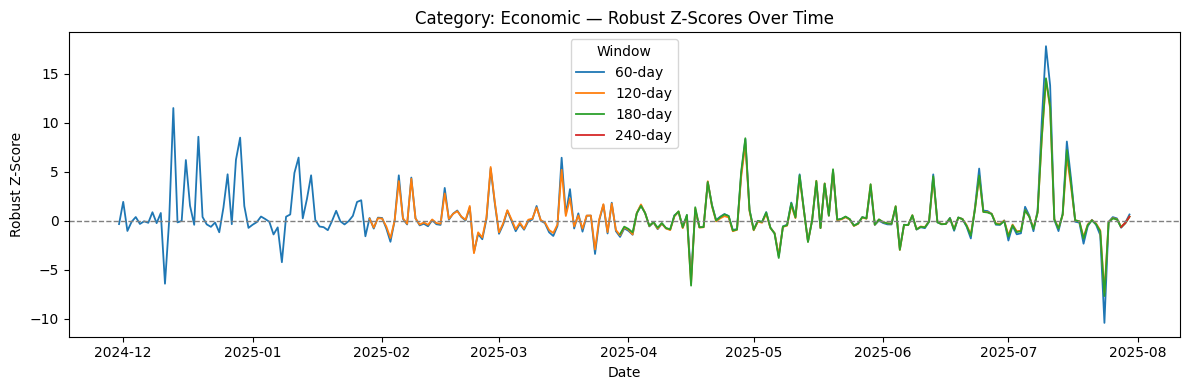

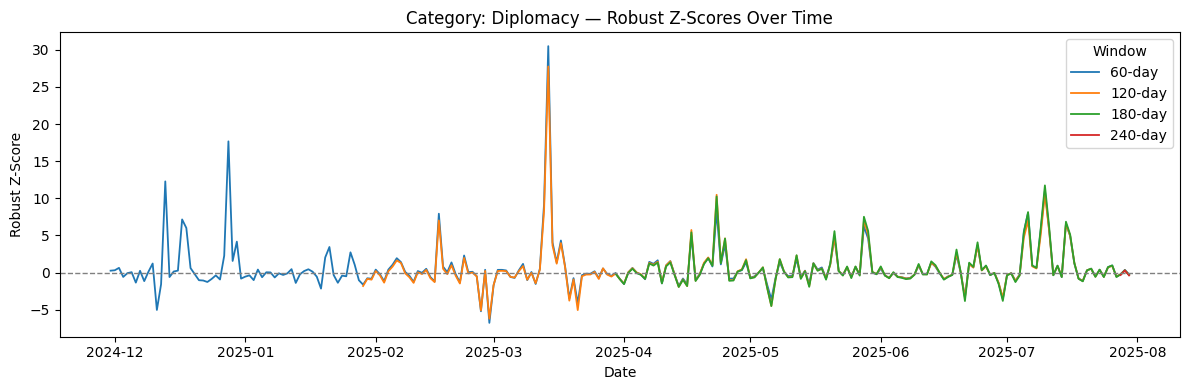

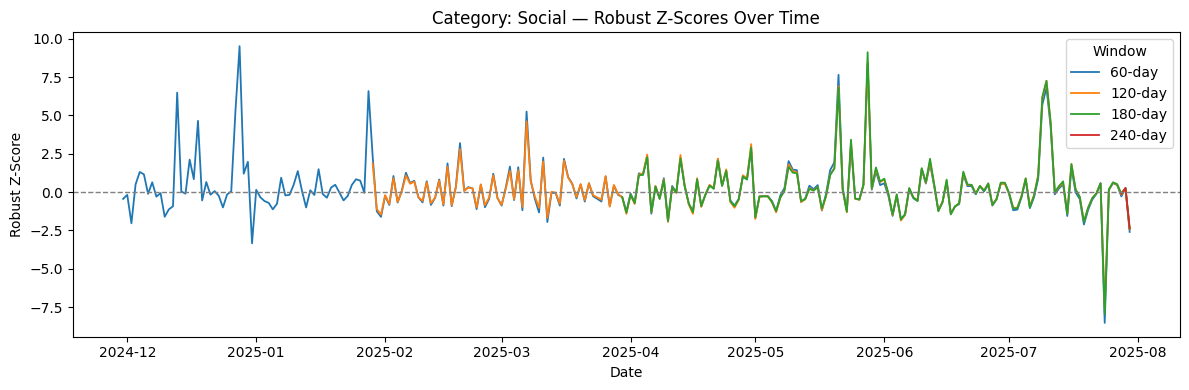

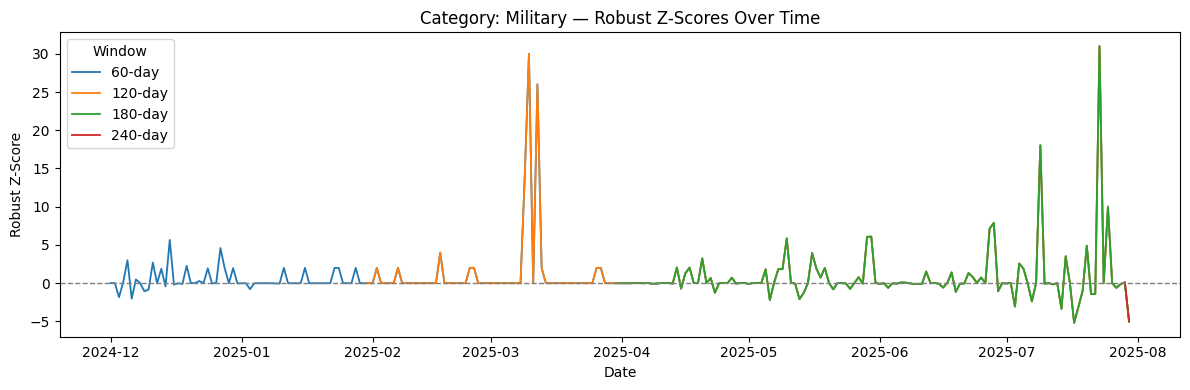

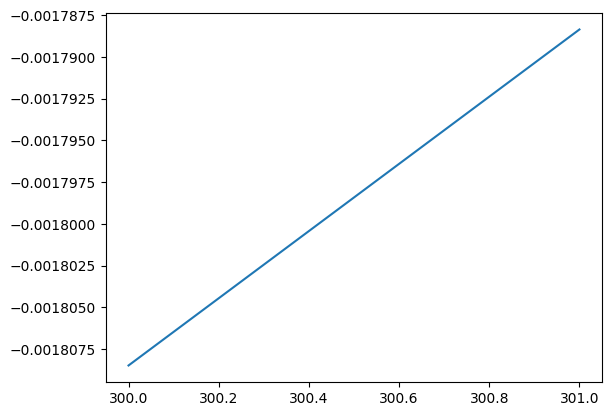

In [10]:
from statsmodels.tsa.seasonal import STL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# if you’re in a notebook:
%matplotlib inline

# Inputs
report_date    = pd.to_datetime(date)
country        = country
windows = {
    "60-day":  60,
    "120-day":120,
    "180-day":180,
    "240-day":240,
    "240-day":300  # new!
}

# Tunable parameters
MAD_FLOOR      = .5      # never divide by an MAD smaller than this
MIN_NONZERO    = 2        # require at least this many non-zero residuals in window
PCT_THRESHOLD  = 0.90     # percentile threshold for “residual”‐based flags

summary_rows = []

for category in ['Economic','Diplomacy','Social','Military']:
    # — fetch & filter —
    df = get_daily_category_article_counts(country=country, category=category)
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'] <= report_date].sort_values('date').copy()
    if df.empty:
        summary_rows.append({"Category":category, **{lbl:np.nan for lbl in windows}})
        continue

    # — pad calendar days —
    df = df.set_index('date')
    full_idx = pd.date_range(df.index.min(), report_date, freq='D')
    df = df.reindex(full_idx).fillna({'doc_count':0})
    df.index.name = 'date'
    df = df.reset_index()

    # — STL to remove weekly seasonality —
    stl = STL(df['doc_count'], period=7, robust=True)
    df['residual'] = stl.fit().resid

    # — compute rolling med/MAD, z, and flags for each window —
    for lbl, w in windows.items():
        # one-day–lagged rolling median (requires full window)
        df[f'med_{lbl}'] = (
            df['residual']
              .rolling(window=w, min_periods=w)
              .median()
              .shift(1)
        )

        # one-day–lagged raw MAD (requires full window)
        raw_mad = (
            df['residual']
              .rolling(window=w, min_periods=w)
              .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
              .shift(1)
        )

        # scale & floor
        scaled_mad = (raw_mad * 1.4826).clip(lower=MAD_FLOOR)
        df[f'mad_{lbl}'] = scaled_mad

        # compute the robust z
        df[f'z_{lbl}'] = (df['residual'] - df[f'med_{lbl}']) / scaled_mad

        # require at least MIN_NONZERO non-zero residuals before trusting z
        nonzero_count = (
            (df['residual'] != 0)
              .rolling(window=w, min_periods=w)
              .sum()
              .shift(1)
        )
        df.loc[nonzero_count < MIN_NONZERO, f'z_{lbl}'] = np.nan

        # flag with |z| > 2
        df[f'anomaly_z2_{lbl}'] = df[f'z_{lbl}'].abs() > 2

        # percentile-based flag on raw residuals
        pct_thr = (
            df['residual']
              .abs()
              .rolling(window=w, min_periods=w)
              .quantile(PCT_THRESHOLD)
              .shift(1)
        )
        df[f'anomaly_pct{int(PCT_THRESHOLD*100)}_{lbl}'] = df['residual'].abs() > pct_thr
        
    # — grab today’s z (or last available) for summary —
    row = {"Category": category}
    for lbl in windows:
        mask = df['date'] == report_date
        if mask.any():
            row[lbl] = float(df.loc[mask, f'z_{lbl}'].iloc[0])
        else:
            row[lbl] = float(df[f'z_{lbl}'].iloc[-1])
    summary_rows.append(row)

    # — plot overlaid z-series —
    plt.figure(figsize=(12, 4))
    for lbl in windows:
        plt.plot(df['date'], df[f'z_{lbl}'], label=lbl, linewidth=1.3)
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title(f"Category: {category} — Robust Z-Scores Over Time")
    plt.xlabel("Date")
    plt.ylabel("Robust Z-Score")
    plt.legend(title="Window")
    plt.tight_layout()
    plt.show()

# assemble final summary
summary_df = pd.DataFrame(summary_rows).set_index("Category").round(2)
df['z_diff'] = df['z_60-day'] - df['z_240-day']
plt.plot(df.index, df['z_diff'])
# — assemble your final summary DataFrame —


In [11]:
summary_df


,60-day,120-day,180-day,240-day
Category,,,,
Economic,0.65,0.42,0.41,0.44
Diplomacy,-0.27,-0.31,-0.31,-0.39
Social,-2.60,-2.43,-2.38,-2.36
Military,-5.01,-5.01,-5.00,-5.00


In [32]:
totals

,date,total_count
0,2025-01-01,43.0
1,2025-01-02,28.0
2,2025-01-03,22.0
3,2025-01-04,16.0
4,2025-01-05,17.0
...,...,...
212,2025-08-01,22.0
213,2025-08-02,41.0
214,2025-08-03,59.0
215,2025-08-04,50.0


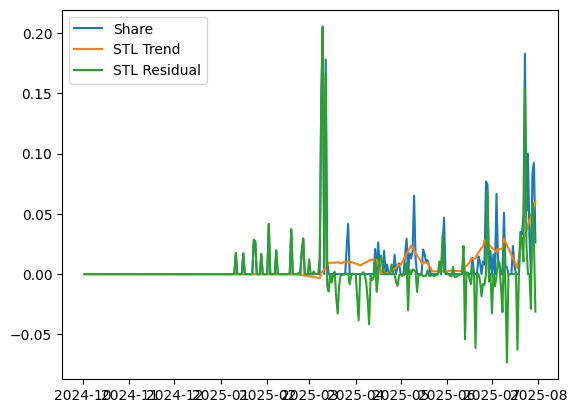

In [33]:
plt.plot(df['date'], df['share'], label='Share')
plt.plot(df['date'], stl.fit().trend, label='STL Trend')
plt.plot(df['date'], df['residual'], label='STL Residual')
plt.legend()
plt.show()

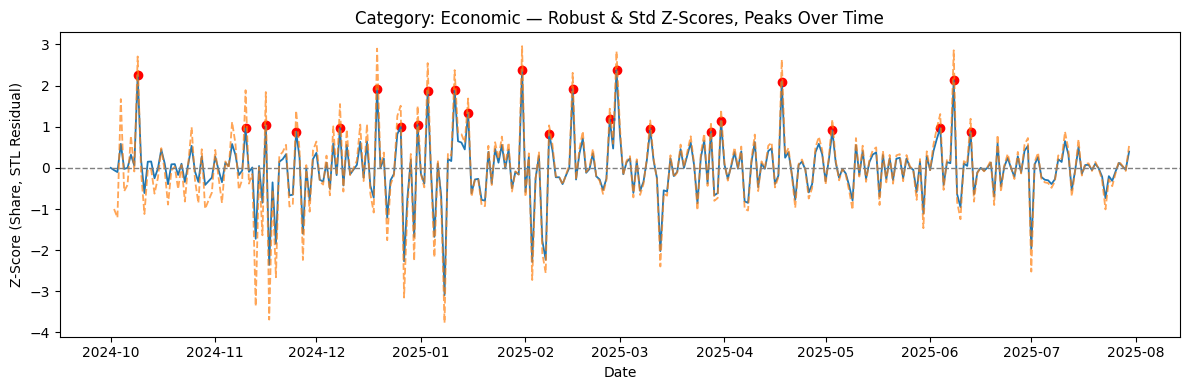

In [38]:
windows = {
    "7-day": 7,
    "14-day":  14,
    "30-day":  30,
    "60-day":  60,
    "120-day":  120,
    "240-day":  240,

}
MAD_FLOOR      = .1
MIN_NONZERO    = 2
PCT_THRESHOLD  = 0.90

# — fetch & filter —
country = 'China'
recipient= None
category = 'Economic'
df = get_daily_category_article_counts(country=country, category=category,recipient=recipient)
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] <= report_date].sort_values('date').copy()
if df.empty:
    summary_rows.append({"Category":category, **{lbl:np.nan for lbl in windows}})
    # continue

# — pad calendar days —
df = df.set_index('date')
full_idx = pd.date_range(df.index.min(), report_date, freq='D')
df = df.reindex(full_idx).fillna({'doc_count':0})
df.index.name = 'date'
df = df.reset_index()
# --- Add total daily volume and compute share ---
df = df.merge(totals, on='date', how='left')
df['total_count'] = df['total_count'].fillna(0)
# Protect against division by zero
df['share'] = np.where(df['total_count'] > 0, df['doc_count'] / df['total_count'], 0)

# --- STL to remove weekly seasonality from share ---
stl = STL(df['share'], period=7, robust=True)
df['residual'] = stl.fit().resid
# --- Rolling stats and anomaly flags for each window ---
lbl = 7
# Robust z-score (already in your script)
df[f'med_{lbl}'] = df['residual'].rolling(window=w, min_periods=1).median()
raw_mad = df['residual'].rolling(window=w, min_periods=1).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
scaled_mad = (raw_mad * 1.4826).clip(lower=MAD_FLOOR)
df[f'mad_{lbl}'] = scaled_mad
df[f'z_{lbl}'] = (df['residual'] - df[f'med_{lbl}']) / scaled_mad

# Non-robust z-score
df[f'mean_{lbl}'] = df['residual'].rolling(window=w, min_periods=1).mean()
df[f'std_{lbl}'] = df['residual'].rolling(window=w, min_periods=1).std(ddof=0)
df[f'z_std_{lbl}'] = (df['residual'] - df[f'mean_{lbl}']) / df[f'std_{lbl}']

nonzero_count = (
    (df['residual'] != 0)
        .rolling(window=w, min_periods=w)
        .sum()
)
df.loc[nonzero_count < MIN_NONZERO, f'z_{lbl}'] = np.nan

df[f'anomaly_z2_{lbl}'] = df[f'z_{lbl}'].abs() > 2

pct_thr = (
    df['residual']
        .abs()
        .rolling(window=w, min_periods=w)
        .quantile(PCT_THRESHOLD)
)
df[f'anomaly_pct{int(PCT_THRESHOLD*100)}_{lbl}'] = df['residual'].abs() > pct_thr

# --- PEAK DETECTION ---
# Detect peaks where z-score exceeds a threshold (e.g., 1)
peaks, properties = find_peaks(df[f'z_{lbl}'], height=.75)
df[f'peaks_{lbl}'] = False
if len(peaks) > 0:
    df.loc[peaks, f'peaks_{lbl}'] = True
# — plot overlaid z-series (SHARE) with peaks highlighted —
plt.figure(figsize=(12, 4))

plt.plot(df['date'], df[f'z_{lbl}'], label=f'Robust Z ({lbl})', linewidth=1.3)
plt.plot(df['date'], df[f'z_std_{lbl}'], label=f'Std Z ({lbl})', linewidth=1.3, linestyle='dashed', alpha=0.7)
# Plot detected robust peaks
peaks = df.index[df[f'peaks_{lbl}']]
plt.scatter(df['date'].iloc[peaks], df[f'z_{lbl}'].iloc[peaks], color='red', marker='o', label=f'Peaks (robust, {lbl})')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title(f"Category: {category} — Robust & Std Z-Scores, Peaks Over Time")
plt.xlabel("Date")
plt.ylabel("Z-Score (Share, STL Residual)")
plt.tight_layout()
plt.show()

In [39]:
t_df = df[df[f'peaks_{lbl}']==True]

In [40]:
t_df

,date,doc_count,total_count,share,residual,med_7,mad_7,z_7,mean_7,std_7,z_std_7,anomaly_z2_7,anomaly_pct90_7,peaks_7
8,2024-10-09,28,55.0,0.509091,0.225148,0.000403,0.1,2.247453,0.027251,0.073129,2.706125,True,False,True
40,2024-11-10,13,25.0,0.520000,0.096495,0.000549,0.1,0.959461,0.008859,0.046452,1.886584,False,False,True
46,2024-11-16,23,52.0,0.442308,0.104412,0.000549,0.1,1.038632,0.004450,0.054258,1.842362,False,False,True
55,2024-11-25,38,98.0,0.387755,0.088490,0.000476,0.1,0.880139,-0.003895,0.066475,1.389775,False,False,True
68,2024-12-08,29,59.0,0.491525,0.097180,0.000403,0.1,0.967771,-0.004864,0.065823,1.550265,False,False,True
79,2024-12-19,40,84.0,0.476190,0.191967,-0.000374,0.1,1.923409,-0.001981,0.066956,2.896648,False,False,True
86,2024-12-26,23,52.0,0.442308,0.099896,0.000172,0.1,0.997241,-0.001390,0.067102,1.509430,False,False,True
91,2024-12-31,9,22.0,0.409091,0.104313,-0.000489,0.1,1.048022,-0.005076,0.072714,1.504374,False,False,True
94,2025-01-03,11,22.0,0.500000,0.185434,-0.001150,0.1,1.865835,-0.003547,0.074256,2.545001,False,False,True
102,2025-01-11,26,57.0,0.456140,0.187580,-0.001150,0.1,1.887298,-0.006483,0.081701,2.375277,False,False,True


In [24]:
date = '2025-06-11'
def get_documents_between(start_date, end_date, country=None, category=None, recipient=None):
    """
    Return all documents dated between start_date and end_date (inclusive),
    optionally filtered by initiating country and category.
    """
    stmt = (
        select(Document.title,Document.date,Document.doc_id,Document.distilled_text)
        # date BETWEEN start_date AND end_date
        .where(
            Document.date >= pd.to_datetime(start_date),
            Document.date <= pd.to_datetime(end_date),
        )
        # join in your existing country and category filters
        .join(InitiatingCountry, Document.doc_id == InitiatingCountry.doc_id)
        .join(RecipientCountry,  Document.doc_id == RecipientCountry.doc_id)
        .filter(
            InitiatingCountry.initiating_country == country,
            RecipientCountry.recipient_country.in_(cfg.recipients),
        )
    )

    if category and category != "ALL":
        stmt = stmt.join(Category, Document.doc_id == Category.doc_id)\
                   .filter(Category.category == category)
    if recipient and recipient != "ALL":
        stmt = stmt.filter(RecipientCountry.recipient_country==recipient)
    with engine.connect() as conn:
        df = pd.read_sql(stmt, conn)

    # dedupe & return
    df = df.drop_duplicates(subset=['doc_id']).reset_index(drop=True)
    return df

# Usage:
start = date
end   = date
docs = get_documents_between(start_date=start, end_date=end,
                             country=country, category=category,recipient=recipient)

In [21]:
reports = docs.to_dict(orient='records')

In [22]:

def build_prompt(country,category,date,reports,recipient=None):
    if recipient:
        statement = f"{country}'s {category} soft power influence towards {recipient}"
    else:
        statement = f"{country}'s {category} soft power influence in the middle east."
    prompt = f'''
    Context:
    On {date}, there was a statistically significant surge (“peak”) in news coverage related to {statement}.
    The following are news article excerpts or summaries published on that date.

    Task:
    Write a concise report that:

    Summarizes the main themes, events, and narratives reported in these articles.

    Explains any key incidents, policy changes, or agreements that are mentioned in the articles that likely explain the peak in reporting.

    Highlights any notable actors, locations, or outcomes that appear in the reporting.

    (Optional) Discusses possible short-term impacts or implications for {statement}.

    Articles:
    {{reports}}

    Instructions:

    Your report should be written for a professional analyst or policymaker.

    Avoid speculation beyond the facts in the articles or broad generalizations.

    If multiple themes are present, group them logically.

    Aim for 2–4 concise paragraphs using html formatting and text width of a standard paper.

    '''
    prompt = prompt.format(statement=statement,date=date,reports=reports)
    return prompt
prompt = build_prompt(country=country,category=category,recipient=recipient,date=start,reports=reports)
sys_prompt = '''You are a professional analyst specializing in global news events and anomaly detection.
Your task is to review a collection of news articles or summaries from a single day in a specific country and category, during which a statistically significant surge (“peak”) in coverage has been detected.

Instructions:

Carefully read and synthesize only the information provided in the articles or summaries.

Structure your report for an audience of policymakers or professional analysts.

Clearly summarize the major themes, incidents, and actors driving the surge in coverage.

Explain, based on the articles, what likely caused this anomalous increase in reporting for the specified category and country.

If multiple distinct themes are present, organize the report into logical groups.

Highlight any immediate impacts or implications, but do not speculate beyond what is justified by the provided content.

Keep your report clear, concise, and focused on factual synthesis and professional insight.

Do not reference statistical methods or z-scores; focus only on analyzing and explaining the significance of the day’s news content.'''



In [23]:
print(prompt)


    Context:
    On 2025-06-11, there was a statistically significant surge (“peak”) in news coverage related to China's Economic soft power influence in the middle east..
    The following are news article excerpts or summaries published on that date.

    Task:
    Write a concise report that:

    Summarizes the main themes, events, and narratives reported in these articles.

    Explains any key incidents, policy changes, or agreements that are mentioned in the articles that likely explain the peak in reporting.

    Highlights any notable actors, locations, or outcomes that appear in the reporting.

    (Optional) Discusses possible short-term impacts or implications for China's Economic soft power influence in the middle east..

    Articles:
    [{'title': 'From economic diplomacy to economy-oriented diplomacy', 'date': datetime.date(2025, 6, 11), 'doc_id': '94f1831a-e068-4d44-91d4-245ccb41f19a', 'distilled_text': 'The text discusses the shift in Iran from traditional economic 

In [24]:
from backend.scripts.utils import gai
response = gai(sys_prompt=sys_prompt,user_prompt=prompt)

In [25]:
from IPython.display import display, HTML
display(HTML(response['choices'][0]['message']['content']))


In [28]:
from scipy.stats import linregress

N = 360  # trailing days
lbl = 120
for i in range(N, len(df)):
    y = df[f'z_{lbl}-day'].iloc[i-N:i]
    x = np.arange(N)
    if not y.isnull().any():
        slope, *_ = linregress(x, y)
        df.loc[df.index[i], f'z_{lbl}_recent_slope'] = slope
    else:
        df.loc[df.index[i], f'z_{lbl}_recent_slope'] = np.nan

plt.plot(df['date'], df[f'z_{lbl}_recent_slope'], label=f'{lbl}d trailing slope')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(); plt.title('Z-score 30d Trailing Slope'); plt.show()

KeyError: 'z_120_recent_slope'

In [ ]:
df

In [29]:
import pandas as pd
from scipy.stats import linregress

# --- Configuration ---
trend_window = 30  # How many trailing days to compute trend metrics over
z_col = 'z_30-day'  # Which z-score window to use

categories = ['Economic', 'Diplomacy', 'Social', 'Military']
summary_rows = []

# for cat in categories:
# If you have a combined df, filter by category:
# df_cat = df[df['category'] == cat].copy()  # Or use your existing per-category df

# Only use rows with valid z-scores in last N days
recent = df.tail(trend_window).dropna(subset=[z_col])
if recent.empty or len(recent) < 3:
    row = {
        'Category': cat,
        'Mean_Z': None,
        '%_Above_1': None,
        'Slope': None,
    }
else:
    mean_z = recent[z_col].mean()
    pct_above_1 = (recent[z_col] > 1).mean() * 100  # as percent
    # Rolling slope (linear regression) over trailing window
    y = recent[z_col].values
    x = range(len(y))
    slope, _, _, _, _ = linregress(x, y)
    row = {
        'Category': cat,
        'Mean_Z': round(mean_z, 2),
        '%_Above_1': round(pct_above_1, 1),
        'Slope': round(slope, 3),
    }
summary_rows.append(row)

trend_table = pd.DataFrame(summary_rows)
print(trend_table)

KeyError: ['z_30-day']

In [ ]:
import pandas as pd
import numpy as np

# assume you already have:
#   df with columns: date (datetime), residual (float)
#   windows = {"30-day":30, "60-day":60, "90-day":90, "120-day":120}
pct = 0.80  # top 5%

all_events = []   # collect each window's events here

for lbl, w in windows.items():
    # 1) compute one-day–lagged rolling percentile threshold
    thr = (
        df['residual']
          .abs()
          .rolling(window=w, min_periods=w)
          .quantile(pct)
          .shift(1)
    )

    # 2) flag anomaly days
    df[f'anom_{lbl}'] = df['residual'].abs() > thr
    # drop days before full window as non-anomalies
    df.loc[thr.isna(), f'anom_{lbl}'] = False

    # 3) number runs of identical flags
    df[f'grp_{lbl}'] = (df[f'anom_{lbl}'] != df[f'anom_{lbl}'].shift()).cumsum()

    # 4) collapse only the True-groups into events
    flagged = df[df[f'anom_{lbl}']]
    if not flagged.empty:
        ev = (
            flagged
              .groupby(f'grp_{lbl}')
              .agg(
                  start    = ('date',  'first'),
                  end      = ('date',  'last'),
                  duration = ('date', lambda rng: (rng.max() - rng.min()).days + 1),
                  peak_res = ('residual', lambda s: s.abs().max())
              )
              .reset_index(drop=True)
        )
        ev['window'] = lbl
        all_events.append(ev)

# 5) concatenate all windows into one DataFrame
events_df = pd.concat(all_events, ignore_index=True)

# events_df now has columns:
#   window   : which rolling window (e.g. "30-day")
#   start    : event start date
#   end      : event end date
#   duration : number of days
#   peak_res : maximum |residual| in that run

print(events_df)

In [ ]:
events_df[events_df['duration'] >2]

In [ ]:
summary_df

In [ ]:
# pick your threshold
THRESH = 10.0
w = 60
# 2) flag anomalies on the 30-day series
df['anomaly'] = df[f'z_{w}-day'].abs() > THRESH

# 3) identify runs of consecutive anomaly days
#    every time `anomaly` changes, increment the group counter
df['grp'] = (df['anomaly'] != df['anomaly'].shift()).cumsum()

# 4) collapse into one “event” per run of anomaly days
events = (
    df[df['anomaly']]                 # only keep the flagged days
      .groupby('grp')                # each run gets its own group
      .agg(
          start   = ('date', 'first'), 
          end     = ('date', 'last'),
          duration = ('date', lambda dr: (dr.max() - dr.min()).days + 1),
          peak_z  = (f'z_{w}-day', lambda s: s.abs().max())
      )
      .reset_index(drop=True)
)

print("Detected events:")
print(events.head(70))

In [ ]:
def get_documents_between(start_date, end_date, country=None, category=None):
    """
    Return all documents dated between start_date and end_date (inclusive),
    optionally filtered by initiating country and category.
    """
    stmt = (
        select(Document.title,Document.date,Document.doc_id)
        # date BETWEEN start_date AND end_date
        .where(
            Document.date >= pd.to_datetime(start_date),
            Document.date <= pd.to_datetime(end_date),
        )
        # join in your existing country and category filters
        .join(InitiatingCountry, Document.doc_id == InitiatingCountry.doc_id)
        .join(RecipientCountry,  Document.doc_id == RecipientCountry.doc_id)
        .filter(
            InitiatingCountry.initiating_country == country,
            RecipientCountry.recipient_country.in_(cfg.recipients),
        )
    )

    if category and category != "ALL":
        stmt = stmt.join(Category, Document.doc_id == Category.doc_id)\
                   .filter(Category.category == category)

    with engine.connect() as conn:
        df = pd.read_sql(stmt, conn)

    # dedupe & return
    df = df.drop_duplicates(subset=['doc_id']).reset_index(drop=True)
    return df

# Usage:
start = "2025-04-28"
end   = "2025-04-30"
docs = get_documents_between(start_date=start, end_date=end,
                             country="China", category="Diplomacy")

In [ ]:
docs.head(50)

In [ ]:


# … your existing code that builds `df` and computes z_{lbl} …

# ——— plot all windows together ———
plt.figure(figsize=(12, 6))



In [ ]:
df

In [ ]:
summary_df

In [ ]:
topic = "Social"
country = "China"    # or whatever your country
mismatches = []

for _, row in daily_summaries.iterrows():
    date = row["date"]
    # 1) parsed count from your summary table
    summary_count = ast.literal_eval(row["count_by_category"]).get(topic, 0)
    # 2) “real” count via your existing helper
    df = get_date_documents(date, country=country, category=topic)
    real_count = len(df)

    if summary_count != real_count:
        mismatches.append({
            "date": date,
            "summary_count": summary_count,
            "real_count":    real_count
        })

if mismatches:
    print("Found count mismatches on these dates:")
    for m in mismatches:
        print(f" • {m['date']}: summary says {m['summary_count']} but real pull gives {m['real_count']}")
else:
    print("All counts match!")

In [ ]:

# 1) redefine your labeling and coloring
def z_label(z: float, window: str) -> str:
    if pd.isna(z): return ""
    if window == "60-day":
        return (
            "Sharp spike"      if z > 2 else
            "Spike"            if z > 1 else
            "Normal"           if z >= -1 else
            "Dip"              if z >= -2 else
            "Sharp drop"
        )
    elif window == "90-day":
        return (
            "Sustained high"   if z > 2 else
            "Elevated trend"   if z > 1 else
            "Stable"           if z >= -1 else
            "Declining trend"  if z >= -2 else
            "Sustained low"
        )
    elif window == "120-day":
        return (
            "Sustained high"   if z > 2 else
            "Elevated trend"   if z > 1 else
            "Stable"           if z >= -1 else
            "Declining trend"  if z >= -2 else
            "Sustained low"
        )
            
    else:  # 30-day
        return (
            "Strong ↑"         if z > 2 else
            "Upward"           if z > 1 else
            "Normal"           if z >= -1 else
            "Downward"         if z >= -2 else
            "Strong ↓"
        )

def z_color(z: float) -> str:
    if pd.isna(z): return ""
    if z > 2:      return "background-color: #1a9850; color:white"
    elif z > 1:    return "background-color: #66c2a5"
    elif z >= -1:  return ""
    elif z >= -2:  return "background-color: #fdae61"
    else:          return "background-color: #d73027; color:white"

formatters = {
    window: (lambda v, w=window: f"{z_label(v, w)} ({v:.2f})")
    for window in ["30-day","60-day","90-day","120-day"]
}

# 2) Start your Styler
styler = summary_df.style

# 3) Register all formatters at once
styler = styler.format(formatters)

# 4) Apply coloring (this can still be done column-by-column)
for window in ["30-day","60-day","90-day","120-day"]:
    styler = styler.applymap(z_color, subset=[window])

In [ ]:
styler

In [ ]:
threshold = 1
window = 120
for topic,i in styler.data.iterrows():
    if i[f'{window}-day'] > threshold:
        #find daily summaries for this topic within the window
        print(topic)
        print(i[f'{window}-day'])
        stmt = select(DailySummary).where(
            # topic is in the category
            
            DailySummary.categories.like(f"%{topic}%"),
            DailySummary.date >= report_date - pd.Timedelta(days=window),
            DailySummary.date <= report_date,
            DailySummary.initiating_country==country
        ).order_by(DailySummary.date.desc())
        with engine.connect() as conn:
            daily_summaries = pd.read_sql(stmt, conn)

In [ ]:
daily_summaries

In [ ]:
topic = 'Social'
daily_summaries[f'{topic}_article_count'] = daily_summaries['count_by_category'].apply(
    lambda x: ast.literal_eval(x).get(topic, 0)
)
daily_summaries['date'] = pd.to_datetime(daily_summaries['date'])

In [ ]:
# 1) Make sure your dates go forward, not backward:
daily_summaries = daily_summaries.sort_values("date")

# 2) Convert your count-by-category JSON into a column
daily_summaries[f"{topic}_article_count"] = (
    daily_summaries["count_by_category"]
      .apply(lambda x: ast.literal_eval(x).get(topic, 0))
)

# 3) Use a rolling window with a smaller min_periods, so you get z-scores
#    even before you hit 30 days—and avoid divide-by-zero.
rolling = daily_summaries[f"{topic}_article_count"].rolling(
    window=window,
    min_periods=1,    # allow at least 2 points
)

mean = rolling.mean()
std  = rolling.std(ddof=0)   # population std; ddof=1 is default

daily_summaries["z_score"] = (daily_summaries[f"{topic}_article_count"] - mean) / std

# 4) Optionally, fill those few remaining NaNs when std==0
daily_summaries["z_score"] = daily_summaries["z_score"].fillna(0)

In [ ]:
daily_summaries

In [ ]:
daily_summaries['significant_change'] = daily_summaries['z_score'].abs() > threshold

In [ ]:
daily_summaries = daily_summaries.sort_values(by="date", ascending=False)
significant_dates = daily_summaries[daily_summaries['z_score'] >= 1]


In [ ]:
significant_dates

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_z_scores(df):
    # make sure dates are sorted
    df = df.sort_values("date")

    plt.figure()
    plt.plot(df["date"], df["z_score"])          # line plot of z‐score over time
    plt.title(f"Daily {topic} Z-Scores Over {window} day sliding window")
    plt.xlabel("Date")
    plt.ylabel("Z-Score")
    plt.xticks(rotation=45)                      # rotate x‐labels so they don’t overlap
    plt.tight_layout()                           # padding so labels are visible
    plt.show()
plot_z_scores(daily_summaries)

In [ ]:
documents_by_date = {}

for date in significant_dates['date']:
    date_documents= get_date_documents(date, country=country, category=topic)
    date_documents = date_documents[['doc_id','source_name','title','distilled_text']]
    date = pd.to_datetime(date).strftime('%Y-%m-%d')
    documents_by_date[date] = date_documents.to_dict(orient='records')

In [ ]:
len(date_documents)

In [ ]:
# find dates with significant changes

significant_dates = daily_summaries[daily_summaries['significant_change']].copy()
significant_dates = significant_dates[['date', f'{topic}_article_count']]
significant_dates = significant_dates.sort_values(by=f'{topic}_article_count', ascending=False)

In [ ]:
significant_dates.head()

In [ ]:

top_significant_dates = significant_dates.head(5)


In [ ]:
top_significant_dates

In [ ]:
len(documents_by_date['2024-10-23'])

In [ ]:
stat_prompt = '''
The following are rolling med, MAD and robust-z scores by 30, 60, 90,120 day windows, their scores align to trends in news reporting of soft power activities within the category. a significant spike was identfied in the {} windows. The following reports fall within those windows, identify what events were driving the spike for that category. 

print(f'rolling med, MAD and robust-z by window: {styler.data.to_html()}')

In [ ]:
series

In [ ]:
raw

In [ ]:
from statsmodels.tsa.seasonal import STL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, select, func, distinct
from backend.scripts.models import Document, Category, InitiatingCountry, RecipientCountry
from SoftPowerCLI.utils.file_utils import Config

# 0) Configuration
DB_HOST      = 'localhost'
DATABASE_URL = f"postgresql://matthew50:softpower@{DB_HOST}:5432/softpower-db"
engine       = create_engine(DATABASE_URL)
cfg          = Config.from_yaml()

country      = 'China'
start_date   = pd.Timestamp("2024-08-01")
end_date     = pd.Timestamp("2025-06-30")
categories   = ['Economic','Diplomacy','Social','Military']

# Anomaly parameters
windows      = {"30-day":30, "60-day":60, "90-day":90, "120-day":120}
MAD_FLOOR    = 0.5       # don't divide by anything smaller
MIN_NONZERO  = 2         # require ≥2 non-zero points before trusting z
pct          = 0.95      # percentile for alternative flag

# 1) Pull raw daily counts
stmt = (
    select(
        func.date_trunc('day', Document.date).label('day'),
        Category.category,
        func.count(distinct(Document.doc_id)).label('doc_count')
    )
    .join(Category,          Category.doc_id          == Document.doc_id)
    .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
    .join(RecipientCountry,  RecipientCountry.doc_id  == Document.doc_id)
    .where(
        Document.date >= start_date,
        Document.date <= end_date,
        InitiatingCountry.initiating_country == country,
        RecipientCountry.recipient_country.in_(cfg.recipients),
    )
    .group_by('day', Category.category)
    .order_by('day')
)
with engine.connect() as conn:
    raw = pd.read_sql(stmt, conn, parse_dates=['day'])
    raw['day'] = raw['day'].dt.tz_convert(None)  
# 2) Pivot & pad calendar (keep Timestamps)
df = (
    raw
    .pivot(index='day', columns='category', values='doc_count')
    .reindex(columns=categories, fill_value=0)
)
full_idx = pd.date_range(start_date, end_date, freq='D')
df = df.reindex(full_idx, fill_value=0)
df.index.name = 'date'

# 3) Decompose + anomaly‐detect per category
results = {}
for cat in categories:
    series = df[cat]

    # 3a) STL decomposition (weekly period), robust=False to preserve spikes
    stl = STL(series, period=7, robust=False).fit()
    resid = stl.resid

    tmp = pd.DataFrame({'residual': resid}, index=series.index)

    # 3b) for each rolling window
    for lbl, w in windows.items():
        # rolling median (one‐day lag)
        med = resid.rolling(window=w, min_periods=1).median().shift(1)

        # rolling raw MAD (one‐day lag)
        mad_raw = (
            resid
              .rolling(window=w, min_periods=1)
              .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
              .shift(1)
        )

        # scale & floor
        mad = (mad_raw * 1.4826).clip(lower=MAD_FLOOR)

        # robust z‐score
        z = (resid - med) / mad

        # mask out windows with too few non-zero points
        nz = (resid != 0).rolling(window=w, min_periods=1).sum().shift(1)
        z[nz < MIN_NONZERO] = np.nan

        # alternative percentile‐based flag (no z needed)
        pct_thr = resid.abs().rolling(window=w, min_periods=1).quantile(pct).shift(1)
        pct_flag = resid.abs() > pct_thr

        tmp[f'z_{lbl}']               = z
        tmp[f'anomaly_z2_{lbl}']      = z.abs() > 2
        tmp[f'anomaly_pct{int((1-pct)*100)}_{lbl}'] = pct_flag.fillna(False)

    results[cat] = tmp

# 4) Plot all four z‐series per category
for cat, tmp in results.items():
    plt.figure(figsize=(12, 4))
    for lbl in windows:
        plt.plot(tmp.index, tmp[f'z_{lbl}'], label=lbl, linewidth=1.3)
    plt.axhline(0, linestyle='--', color='gray')
    plt.xlim(start_date, end_date)
    plt.title(f"{cat} — STL(robust=False) residual‐based z-scores")
    plt.xlabel("Date")
    plt.ylabel("Z‐score")
    plt.legend(title="Window")
    plt.tight_layout()
    plt.show()


In [ ]:
country = 'China'
category = 'Economic'
stmt = (
    select(
        func.date_trunc('day', Document.date).label('day'),
        Category.category,
        func.count(distinct(Document.doc_id)).label('doc_count')
    )
    .join(Category,          Category.doc_id          == Document.doc_id)
    .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
    .join(RecipientCountry,  RecipientCountry.doc_id  == Document.doc_id)
    .where(
        Document.date >= start_date,
        Document.date <= end_date,
        InitiatingCountry.initiating_country == country,
        RecipientCountry.recipient_country.in_(cfg.recipients),
    )
    .group_by('day', Category.category)
    .order_by('day')
)
with engine.connect() as conn:
    raw = pd.read_sql(stmt, conn, parse_dates=['day'])

In [ ]:
raw

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, select, func, distinct
from backend.scripts.models import Document, Category, InitiatingCountry, RecipientCountry
from SoftPowerCLI.utils.file_utils import Config

# — 0) CONFIGURATION — 
DB_HOST      = 'localhost'
DATABASE_URL = f"postgresql://matthew50:softpower@{DB_HOST}:5432/softpower-db"
engine       = create_engine(DATABASE_URL)
cfg          = Config.from_yaml()

country      = 'China'
start_date   = pd.Timestamp("2024-08-01")
end_date     = pd.Timestamp("2025-06-30")
categories   = ['Economic','Diplomacy','Social','Military']

# anomaly params
windows      = {"30-day":30, "60-day":60, "90-day":90, "120-day":120}
MAD_FLOOR    = 1       # floor to avoid inf z’s
MIN_NONZERO  = 2         # require ≥2 non-zero days before trusting z

# — 1) FETCH raw daily counts from Postgres —  
stmt = (
    select(
        func.date_trunc('day', Document.date).label('day'),
        Category.category,
        func.count(distinct(Document.doc_id)).label('doc_count')
    )
    .join(Category,          Category.doc_id          == Document.doc_id)
    .join(InitiatingCountry, InitiatingCountry.doc_id == Document.doc_id)
    .join(RecipientCountry,  RecipientCountry.doc_id  == Document.doc_id)
    .where(
        Document.date >= start_date,
        Document.date <= end_date,
        InitiatingCountry.initiating_country == country,
        RecipientCountry.recipient_country.in_(cfg.recipients),
    )
    .group_by('day', Category.category)
    .order_by('day')
)

with engine.connect() as conn:
    raw = pd.read_sql(stmt, conn, parse_dates=['day'])

# strip the tz so pivot + reindex will line up
raw['day'] = raw['day'].dt.tz_localize(None)

# — 2) PIVOT & PAD the calendar —  
df = (
    raw
    .pivot(index='day', columns='category', values='doc_count')
    .reindex(columns=categories, fill_value=0)
)
full_idx = pd.date_range(start_date, end_date, freq='D')
df = df.reindex(full_idx, fill_value=0)
df.index.name = 'date'

# quick sanity check
print("Counts on 2024-08-01:", df.loc["2024-08-01"])

# — 3) ROLLING MEDIAN/MAD → ROBUST Z on RAW COUNTS —  
results = {}
for cat in categories:
    series = df[cat]
    tmp    = pd.DataFrame({'count': series}, index=series.index)

    for lbl, w in windows.items():
        # 3a) one-day–lagged rolling median
        m = tmp['count'].rolling(window=w, min_periods=1).median().shift(1)

        # 3b) one-day–lagged rolling MAD
        mad = (
            tmp['count']
              .rolling(window=w, min_periods=1)
              .apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
              .shift(1)
        ) * 1.4826                # scale
        mad = mad.clip(lower=MAD_FLOOR)

        # 3c) compute z
        z = (tmp['count'] - m) / mad

        # 3d) mask windows with too few non-zero days
        nz = (tmp['count'] != 0).rolling(window=w, min_periods=1).sum().shift(1)
        z[nz < MIN_NONZERO] = np.nan

        tmp[f'z_{lbl}'] = z
        tmp[f'anom_{lbl}'] = z.abs() > 2

    results[cat] = tmp

# — 4) PLOT & VERIFY —  
for cat, tmp in results.items():
    plt.figure(figsize=(12,4))
    for lbl in windows:
        plt.plot(tmp.index, tmp[f'z_{lbl}'], label=lbl, linewidth=1.3)
    plt.axhline(0, linestyle='--', color='gray')
    plt.xlim(start_date, end_date)
    plt.title(f"{cat} — Robust z on raw counts")
    plt.xlabel("Date")
    plt.ylabel("Z-score")
    plt.legend(title="Window")
    plt.tight_layout()
    plt.show()
